<a href="https://colab.research.google.com/github/shahriar2203041/python_041/blob/main/ECG_LowPass_Filter_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install wfdb requests

In [ ]:
# Restart runtime after installing new libraries to ensure they are loaded correctly
import os
os.kill(os.getpid(), 9)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import wfdb
import os
import requests

In [ ]:
# Define the record and database
record_name = '100'
database_name = 'mitdb'

# Define a specific local download directory
download_dir = 'ecg_data_manual'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    print(f"Created directory: {download_dir}")

# Base URL for the MIT-BIH Arrhythmia Database on PhysioNet
base_url = f"https://physionet.org/files/mitdb/1.0.0/{record_name}"

# Files to download for a WFDB record
file_extensions = ['.hea', '.dat']

print(f"Manually downloading record '{record_name}' files to '{download_dir}'...")

for ext in file_extensions:
    file_url = f"{base_url}{ext}"
    local_file_path = os.path.join(download_dir, f"{record_name}{ext}")

    try:
        response = requests.get(file_url, stream=True)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

        with open(local_file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded: {local_file_path}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {file_url}: {e}")
        raise # Re-raise the exception to stop execution if download fails

# Now that files are downloaded locally, read them using wfdb.rdrecord
print(f"Reading record '{record_name}' from local files in '{download_dir}'...")
# Pass the full local path to the record, without specifying pn_dir
record = wfdb.rdrecord(os.path.join(download_dir, record_name))

# Extract the first lead of the ECG signal
ecg_signal = record.p_signal[:, 0]
sampling_rate = record.fs # Get the sampling frequency from the record

print(f"ECG signal '{record_name}' loaded successfully with sampling rate: {sampling_rate} Hz")

# Create a time vector for plotting and saving
time = np.arange(len(ecg_signal)) / sampling_rate

# Select a short segment for easier visualization and CSV saving
segment_start_sec = 0
segment_end_sec = 10 # Using 10 seconds for demonstration
segment_start_idx = int(segment_start_sec * sampling_rate)
segment_end_idx = int(segment_end_sec * sampling_rate)

ecg_segment_time = time[segment_start_idx:segment_end_idx]
ecg_segment_signal = ecg_signal[segment_start_idx:segment_end_idx]

# Save the raw ECG segment to a CSV file inside the download_dir
df_ecg_raw = pd.DataFrame({'Time': ecg_segment_time, 'ECG_Signal': ecg_segment_signal})
raw_csv_path = os.path.join(download_dir, 'ecg_raw_signal.csv')
df_ecg_raw.to_csv(raw_csv_path, index=False)

print(f"Raw ECG signal segment saved to '{raw_csv_path}' for the first {segment_end_sec} seconds.")

Manually downloading record '100' files to 'ecg_data_manual'...
Downloaded: ecg_data_manual/100.hea
Downloaded: ecg_data_manual/100.dat
Reading record '100' from local files in 'ecg_data_manual'...
ECG signal '100' loaded successfully with sampling rate: 360 Hz
Raw ECG signal segment saved to 'ecg_data_manual/ecg_raw_signal.csv' for the first 10 seconds.


In [ ]:
# Define the same download directory to locate the CSV
download_dir = 'ecg_data_manual'
raw_csv_path = os.path.join(download_dir, 'ecg_raw_signal.csv')

# Load the ECG data from the CSV file
df_loaded_ecg = pd.read_csv(raw_csv_path)
time_ecg = df_loaded_ecg['Time'].values
signal_to_filter_ecg = df_loaded_ecg['ECG_Signal'].values # This variable is crucial!

print(f"ECG signal loaded from '{raw_csv_path}'")

ECG signal loaded from 'ecg_data_manual/ecg_raw_signal.csv'


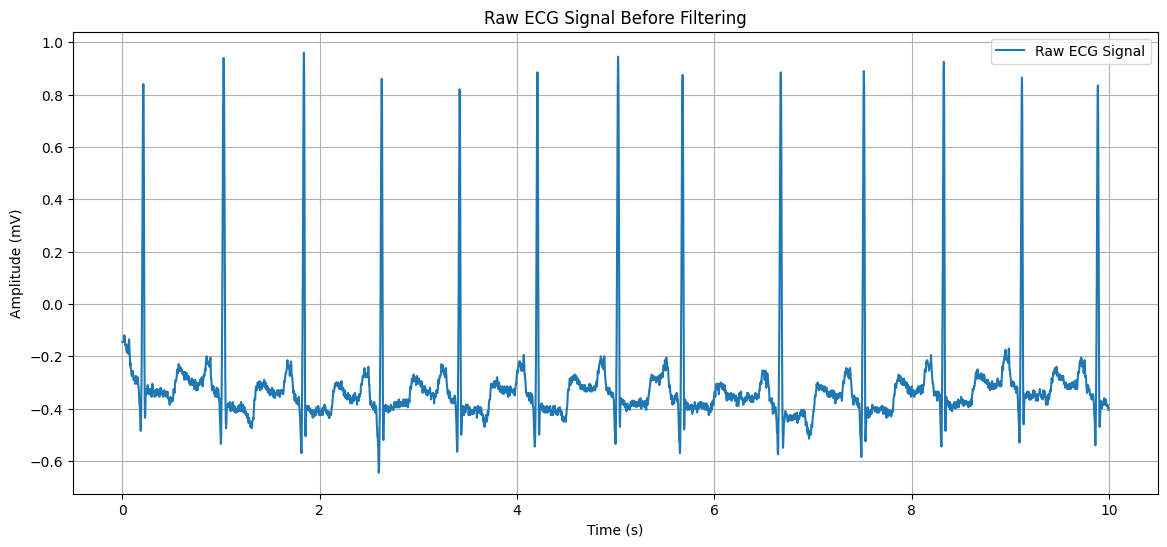

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(time_ecg, signal_to_filter_ecg, label='Raw ECG Signal')
plt.title('Raw ECG Signal Before Filtering')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Design the low-pass filter for ECG
# ECG signals typically have significant information up to around 20-30 Hz.
# Frequencies above this are often considered noise (e.g., muscle artifact).
ecg_cutoff_freq = 30  # Hz - You can adjust this cutoff frequency
nyquist_freq_ecg = 0.5 * sampling_rate # Nyquist frequency is half the sampling rate
normal_cutoff_ecg = ecg_cutoff_freq / nyquist_freq_ecg
order_ecg = 4 # Order of the filter. Higher order means a sharper (steeper) cutoff.

# Calculate the filter coefficients (b and a)
b_ecg, a_ecg = butter(order_ecg, normal_cutoff_ecg, btype='low', analog=False)

# Apply the filter to the ECG signal
filtered_ecg_signal = lfilter(b_ecg, a_ecg, signal_to_filter_ecg)

print(f"Low-pass filter applied to ECG signal with cutoff frequency: {ecg_cutoff_freq} Hz and filter order: {order_ecg}")

Low-pass filter applied to ECG signal with cutoff frequency: 30 Hz and filter order: 4


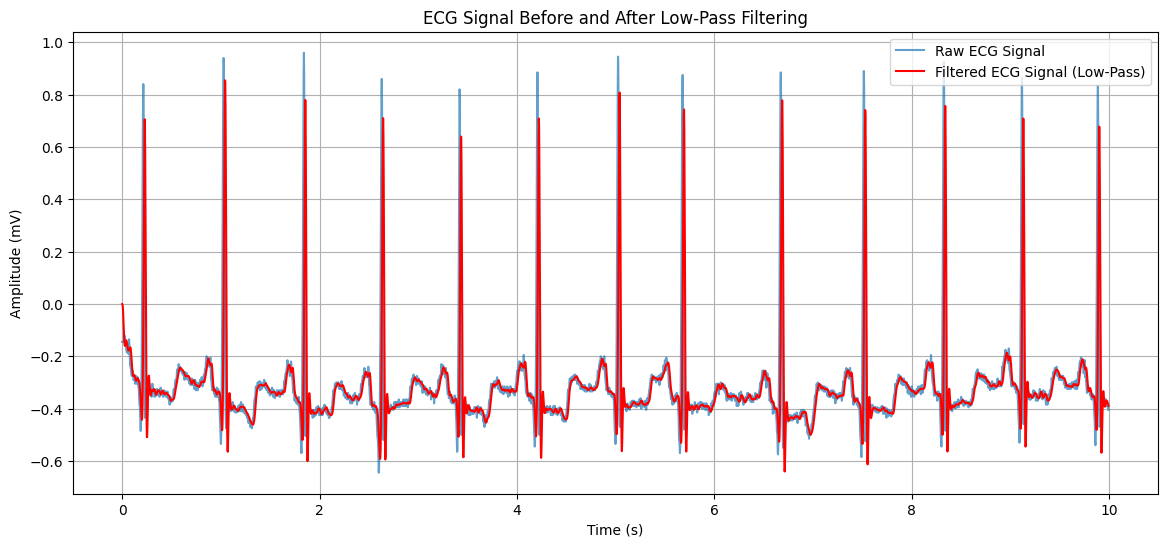

Filtered ECG signal data saved to 'ecg_data_manual/ecg_filtered_signal.csv'


In [ ]:
# Define the same download directory to save the filtered CSV
download_dir = 'ecg_data_manual' # Match the directory name

# Plot the original and filtered signals
plt.figure(figsize=(14, 6))
plt.plot(time_ecg, signal_to_filter_ecg, label='Raw ECG Signal', alpha=0.7) # Original signal (slightly transparent)
plt.plot(time_ecg, filtered_ecg_signal, label='Filtered ECG Signal (Low-Pass)', color='red') # Filtered signal
plt.title('ECG Signal Before and After Low-Pass Filtering')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)
plt.show()

# Save the filtered ECG data to a new CSV file inside the download_dir
df_ecg_filtered = pd.DataFrame({'Time': time_ecg, 'Filtered_ECG_Signal': filtered_ecg_signal})
filtered_csv_path = os.path.join(download_dir, 'ecg_filtered_signal.csv')
df_ecg_filtered.to_csv(filtered_csv_path, index=False)

print(f"Filtered ECG signal data saved to '{filtered_csv_path}'")